ubah runtime ke GPU

In [1]:
!mkdir -p ~/.kaggle #bikin folder di kaggle root
!cp kaggle.json ~/.kaggle # copy paster kaggle.json ke folder kaggle 

!mkdir ./kaggle #bikin folder kaggle di lokasi sama (bukan di root)
!mv ./kaggle.json ./kaggle #move atau pindahi file kaggle.json ke folder kaggle


In [2]:
!chmod 600 ~/.kaggle/kaggle.json #perizinan akses, hanya pemilik file yang memiliki akses baca dan tulis ke file
!ls ~/.kaggle #cek list data yang ada di folder kaggle


kaggle.json


In [3]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

 99% 1.16G/1.17G [00:04<00:00, 223MB/s]
100% 1.17G/1.17G [00:04<00:00, 273MB/s]


In [4]:
!unzip -q /content/labeled-chest-xray-images.zip -d images #nama folder

In [5]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten

from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')


In [6]:
os.listdir('/content/images/chest_xray')

['test', 'train']

In [7]:
main_path = '/content/images/chest_xray'

In [8]:
train_dir = os.path.join(main_path,'train')
test_dir = os.path.join(main_path,'test')

In [9]:
print('test set: \n' + '='*50)
num_pneumonia= len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
num_normal= len(os.listdir(os.path.join(test_dir, 'NORMAL')))
print(f'jumlah pneumonia= {num_pneumonia}')
print(f'jumlah normal= {num_normal}')


test set: 
jumlah pneumonia= 390
jumlah normal= 234


In [10]:
print('train set: \n' + '='*50)
num_pneumonia_train= len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal_train= len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f'jumlah pneumonia= {num_pneumonia_train}')
print(f'jumlah normal= {num_normal_train}')


train set: 
jumlah pneumonia= 3883
jumlah normal= 1349


In [11]:
train_normal = glob.glob(train_dir+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_dir+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_dir+"/PNEUMONIA/*.jpeg")


In [12]:
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        ##ambil nama dari file \ ke -1
        # images.append(image.split('\')[-1]) 
        # label.append(image.split('\')[-2])
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

train_df = create_dataframe(train_normal + train_pneumonia)
train_df = train_df.sample(frac=1, random_state=1).reset_index(drop=True)

test_df = create_dataframe(test_normal + test_pneumonia)
test_df = test_df.sample(frac=1, random_state=1).reset_index(drop=True)


In [15]:
print(train_df.shape)
train_df.head()

(5232, 2)


,images,label
0,/content/images/chest_xray/train/PNEUMONIA/BAC...,PNEUMONIA
1,/content/images/chest_xray/train/PNEUMONIA/BAC...,PNEUMONIA
2,/content/images/chest_xray/train/NORMAL/NORMAL...,NORMAL
3,/content/images/chest_xray/train/NORMAL/NORMAL...,NORMAL
4,/content/images/chest_xray/train/NORMAL/NORMAL...,NORMAL


In [16]:
# from sklearn.model_selection import train_test_split
# train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=1)
# print(train_df.shape)
# print(val_df.shape)

(4708, 2)
(524, 2)


In [17]:
from sklearn.model_selection import train_test_split
val_df, test_df = train_test_split(test_df, test_size=0.05, random_state=1)
print(test_df.shape)
print(val_df.shape)

(32, 2)
(592, 2)


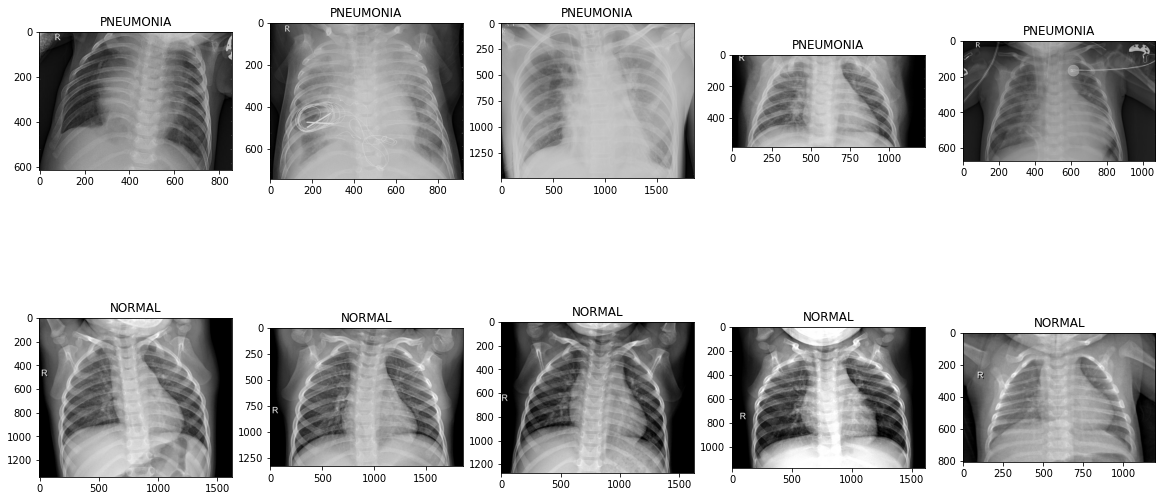

In [18]:
pneumonia_samples = (train_df[train_df['label']=="PNEUMONIA"]['images'].iloc[:5]).tolist()
normal_samples = (train_df[train_df['label']=='NORMAL']['images'].iloc[:5]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(pneumonia_samples + normal_samples)


In [39]:
img_height = 220
img_width = 220
SEED = 1
BATCH = 32
# biar output notebooknya stabil
np.random.seed(42)
tf.random.set_seed(42)

In [40]:
# Augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255, #normalisasi pixel
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

vaL_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [41]:
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width), #ini buat nentuin target biar sama sizenya
    class_mode='binary',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

ds_val = vaL_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

df_test = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    seed=SEED)

Found 4708 validated image filenames belonging to 2 classes.
Found 592 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.


In [42]:
ds_train.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [43]:
#callbakcs

callbacks_aja = [
      EarlyStopping(monitor='val_loss', mode='min', patience = 3,verbose=1),
      ModelCheckpoint('model_best.hdf5',monitor='val_loss', save_best_only=True),
      #reduceLROnPlateu

]

In [44]:
# input= [img_height,img_width,3]

# model_annisa= Sequential()

# #Conv 1
# model_annisa.add(Conv2D(filters=16,kernel_size=3, activation= 'relu', input_shape=input)) #kernel_initializer
# model_annisa.add(MaxPooling2D(pool_size=2, strides=2)) #bisa atur padding
# #dropout atau batch norm

# #Conv 2
# model_annisa.add(Conv2D(filters=32,kernel_size=3, activation= 'relu')) #kernel_initializer
# model_annisa.add(MaxPooling2D(pool_size=2, strides=2)) #bisa atur padding

# model_annisa.add(Flatten())
# model_annisa.add(Dense(units=128, activation='relu'))
# model_annisa.add(Dense(units=1, activation='sigmoid'))


In [45]:
from matplotlib.cbook import flatten
input = [img_height,img_width,3]

model_hanz = Sequential()

#conv1
model_hanz.add(Conv2D(filters=16,kernel_size=3,activation='relu',input_shape=input)) # aturn nilai kernel initializer
model_hanz.add(MaxPooling2D(pool_size=2,strides=2))# bisa atur padding
#dropout atau batch norm


#conv2
model_hanz.add(Conv2D(filters=32,kernel_size=3,activation='relu')) # aturn nilai kernel initializer
model_hanz.add(MaxPooling2D(pool_size=2,strides=2))# bisa atur padding

model_hanz.add(Flatten())
model_hanz.add(Dense(units=128, activation='relu'))
model_hanz.add(Dense(units=128, activation='relu'))
model_hanz.add(Dense(units=1, activation='sigmoid'))




In [46]:
model_hanz.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 218, 218, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 109, 109, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 107, 107, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 89888)             0         
                                                                 
 dense_5 (Dense)             (None, 128)              

In [47]:
model_hanz.compile(optimizer='adam',loss='binary_crossentropy', metrics='accuracy')

In [48]:
history = model_hanz.fit(ds_train,batch_size=BATCH,epochs=10,
                         validation_data=ds_val,callbacks=callbacks_aja,verbose=1)

Epoch 1/10
148/148 [==============================] - 93s 627ms/step - loss: 0.3968 - accuracy: 0.8214 - val_loss: 0.4173 - val_accuracy: 0.7922
Epoch 2/10
148/148 [==============================] - 91s 613ms/step - loss: 0.2797 - accuracy: 0.8781 - val_loss: 0.2867 - val_accuracy: 0.8649
Epoch 3/10
148/148 [==============================] - 91s 617ms/step - loss: 0.2920 - accuracy: 0.8647 - val_loss: 0.3194 - val_accuracy: 0.8666
Epoch 4/10
148/148 [==============================] - 90s 609ms/step - loss: 0.2863 - accuracy: 0.8791 - val_loss: 0.3790 - val_accuracy: 0.8108
Epoch 5/10
148/148 [==============================] - 91s 613ms/step - loss: 0.2605 - accuracy: 0.8879 - val_loss: 0.2524 - val_accuracy: 0.8970
Epoch 6/10
148/148 [==============================] - 90s 608ms/step - loss: 0.2591 - accuracy: 0.8925 - val_loss: 0.3592 - val_accuracy: 0.8176
Epoch 7/10
148/148 [==============================] - 91s 614ms/step - loss: 0.2324 - accuracy: 0.9019 - val_loss: 0.2343 - val_ac

In [49]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = image.load_img(path, target_size=(220,220)) #inget mesti sesuai input yg sebelumnya
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = model_hanz.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  print(classes) 
  if classes[0][0] == 1:
    print('pneumonia')
  else:
    print('normal')


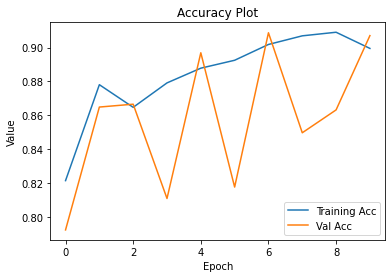

In [50]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()


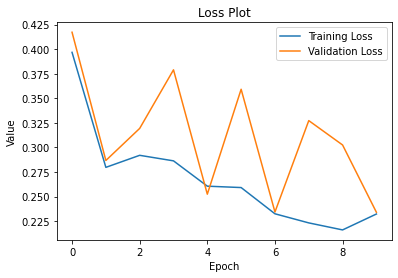

In [51]:
#loss train & validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()
